In [10]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from mpl_toolkits import mplot3d
torch.manual_seed(1)
#https://www.kaggle.com/aakashns/pytorch-basics-linear-regression-from-scratch
#https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/

In [11]:
# Setup the actual data and simulated data
X = torch.arange(-3, 3, 0.1).view(-1, 1)
f = 1 * X - 1
Y = f + 0.1 * torch.randn(X.size())

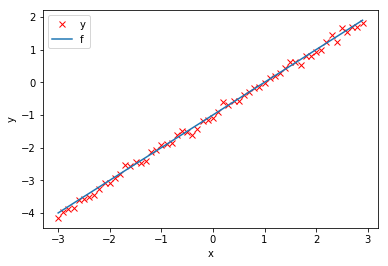

In [12]:
# Plot out the data dots and line
plt.plot(X.numpy(), Y.numpy(), 'rx', label = 'y')
plt.plot(X.numpy(), f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [14]:
X_b = np.hstack((np.ones_like(X.numpy()), X.numpy())) #include bias unit

In [16]:
#analytical - compare with LRM_numpy notebook
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y.numpy())
theta_best

array([[-1.0222366],
       [ 1.0063654]], dtype=float32)

In [7]:
# The class for plot the diagram

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1,cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
    
    # Setter
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1
        self.W.append(W)
        self.B.append(B)
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label = "training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

In [17]:
# Define the forward function
def forward(x):
    return w * x + b

In [18]:
def criterion(yhat, y):
    return torch.mean((yhat - y) ** 2)

<Figure size 432x288 with 0 Axes>

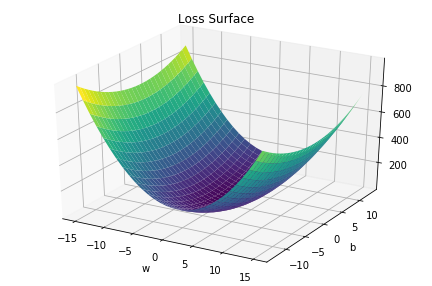

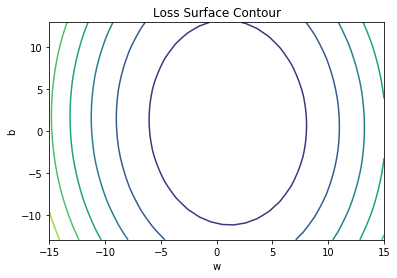

In [19]:
# Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 13, X, Y, 30)

<h2 id="BGD">Train the Model: Batch Gradient Descent</h2>
Create model parameters <code>w</code>, <code>b</code> by setting the argument <code>requires_grad</code> to True because the system must learn it.

In [22]:
# Define the parameters w, b for y = wx + b
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

In [23]:
#Define learning rate and create an empty list for containing the loss for each iteration.
lr = 0.1
LOSS_BGD = []

In [24]:
# The function for training the model
def train_model(iter):
    
    # Loop
    for epoch in range(iter):
        
        # make a prediction
        Yhat = forward(X)
        
        # calculate the loss 
        loss = criterion(Yhat, Y)

        # Section for plotting
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        get_surface.plot_ps()
            
        # store the loss in the list LOSS_BGD
        LOSS_BGD.append(loss)
        
        # backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        
        # update parameters slope and bias
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        
        # zero the gradients before running the backward pass
        w.grad.data.zero_()
        b.grad.data.zero_()

Run 10 epochs of batch gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 

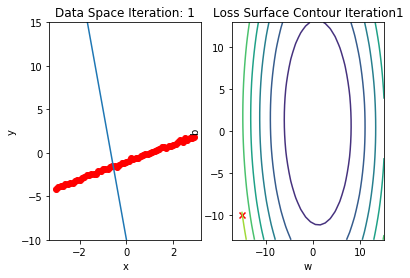

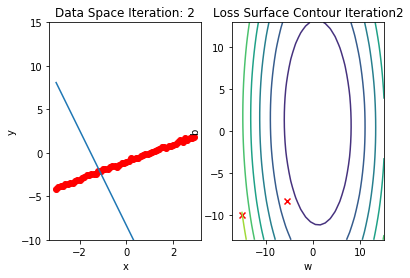

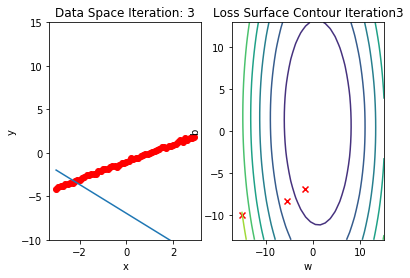

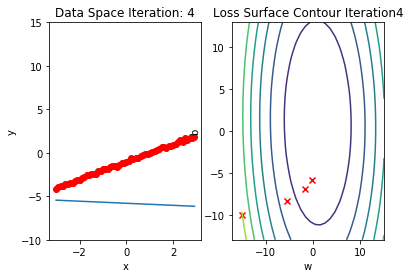

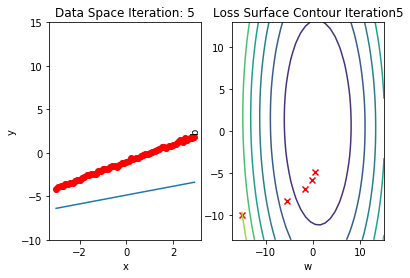

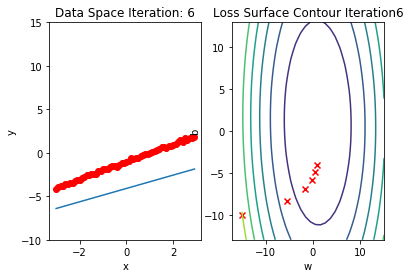

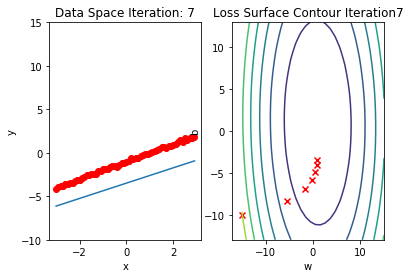

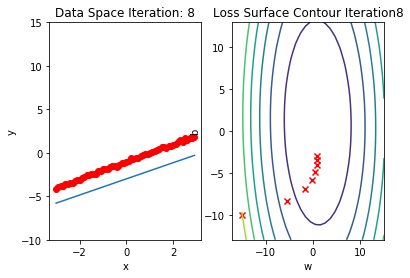

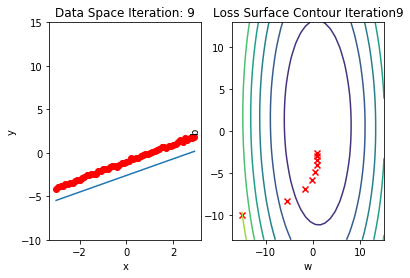

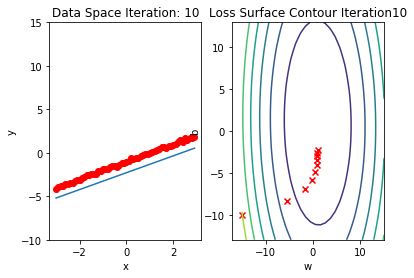

In [26]:
train_model(10)

<h2 id="SGD">Train the Model: Stochastic Gradient Descent</h2>

In [27]:
#Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

In [29]:
# The function for training the model

LOSS_SGD = []
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

def train_model_SGD(iter):
    
    # Loop
    for epoch in range(iter):
        
        # SGD is an approximation of out true total loss/cost, in this line of code we calculate our true loss/cost and store it
        Yhat = forward(X)

        # store the loss 
        LOSS_SGD.append(criterion(Yhat, Y).tolist())
        
        for x, y in zip(X, Y):
            
            # make a pridiction
            yhat = forward(x)
        
            # calculate the loss 
            loss = criterion(yhat, y)

            # Section for plotting
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        
            # backward pass: compute gradient of the loss with respect to all the learnable parameters
            loss.backward()
        
            # update parameters slope and bias
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data

            # zero the gradients before running the backward pass
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        #plot surface and data space after each epoch    
        get_surface.plot_ps()

Run 10 epochs of stochastic gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 

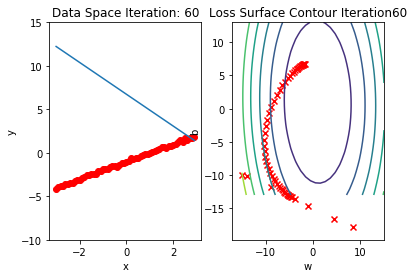

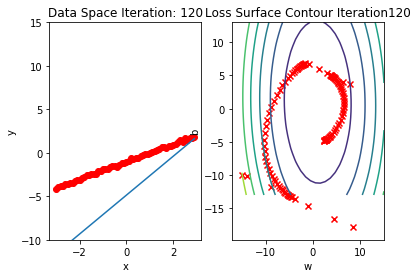

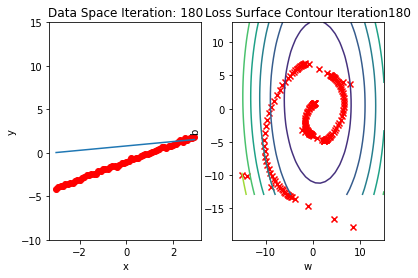

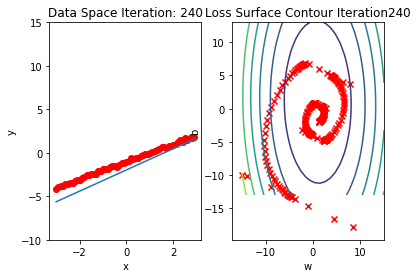

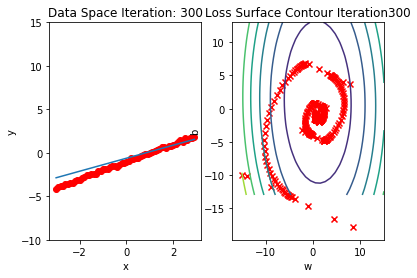

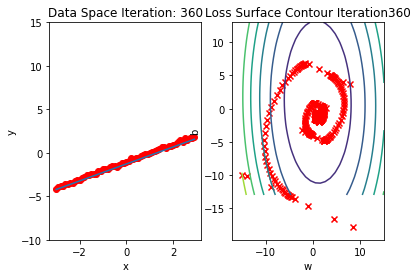

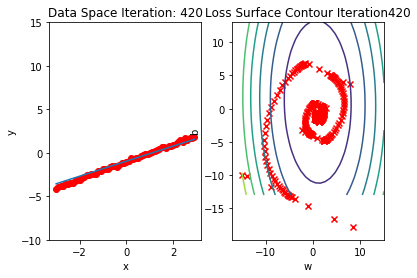

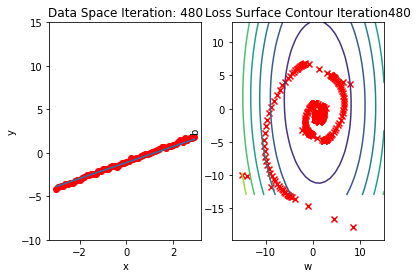

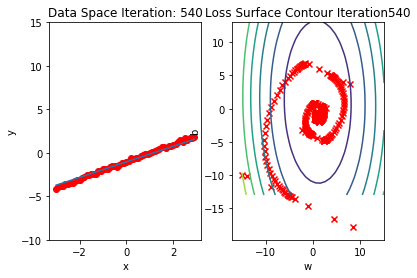

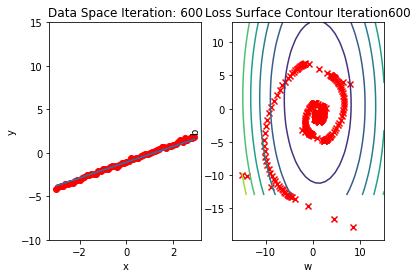

In [30]:
# Train the model with 10 iterations

train_model_SGD(10)

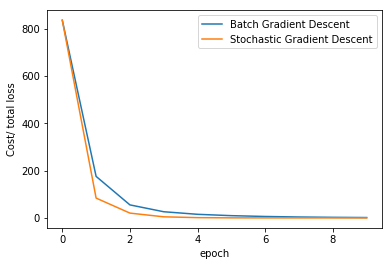

In [32]:
# Plot out the LOSS_BGD and LOSS_SGD
plt.plot(LOSS_BGD,label = "Batch Gradient Descent")
plt.plot(LOSS_SGD,label = "Stochastic Gradient Descent")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

<h2 id="SGD_Loader">SGD with Dataset DataLoader</h2>

In [33]:
# Import the library for DataLoader
from torch.utils.data import Dataset, DataLoader

In [34]:
# Dataset Class
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        self.y = 1 * self.x - 1
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):    
        return self.x[index], self.y[index]
    
    # Return the length
    def __len__(self):
        return self.len

In [35]:
# Create the dataset and check the length
dataset = Data()
print("The length of dataset: ", len(dataset))

The length of dataset:  60


In [36]:
# Print the first point
x, y = dataset[0]
print("(", x, ", ", y, ")")

( tensor([-3.]) ,  tensor([-4.]) )


In [37]:
# Print the first 3 point
x, y = dataset[0:3]
print("The first 3 x: ", x)
print("The first 3 y: ", y)

The first 3 x:  tensor([[-3.0000],
        [-2.9000],
        [-2.8000]])
The first 3 y:  tensor([[-4.0000],
        [-3.9000],
        [-3.8000]])


In [55]:
# Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

In [56]:
# Create DataLoader
trainloader = DataLoader(dataset = dataset, batch_size = 1)

In [57]:
# The function for training the model

w = torch.tensor(-15.0,requires_grad=True)
b = torch.tensor(-10.0,requires_grad=True)
LOSS_Loader = []

def train_model_DataLoader(epochs):
    
    # Loop
    for epoch in range(epochs):
        
        # SGD is an approximation of out true total loss/cost, in this line of code we calculate our true loss/cost and store it
        Yhat = forward(X)
        
        # store the loss 
        LOSS_Loader.append(criterion(Yhat, Y).tolist())
        
        for x, y in trainloader:
            
            # make a prediction
            yhat = forward(x)
            
            # calculate the loss
            loss = criterion(yhat, y)
            
            # Section for plotting
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            
            # Backward pass: compute gradient of the loss with respect to all the learnable parameters
            loss.backward()
            
            # Updata parameters slope
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr* b.grad.data
            
            # Clear gradients 
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        #plot surface and data space after each epoch    
        get_surface.plot_ps()

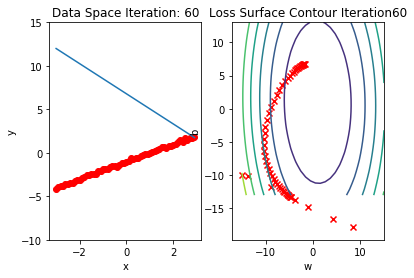

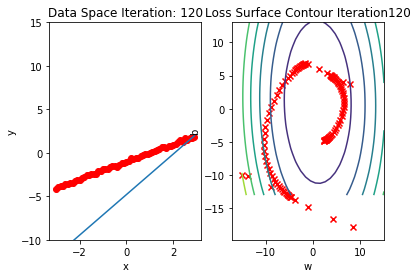

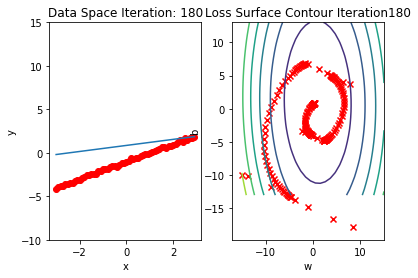

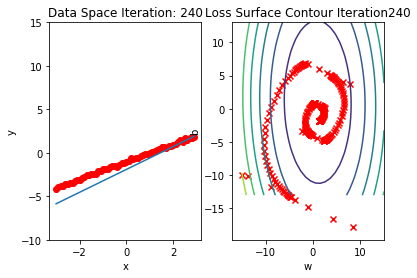

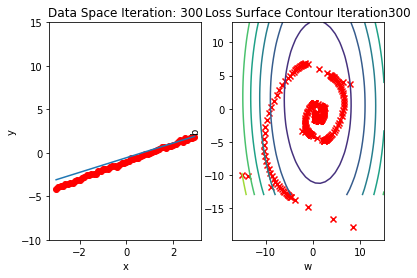

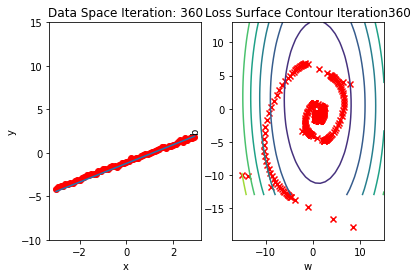

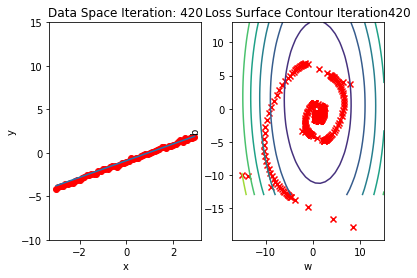

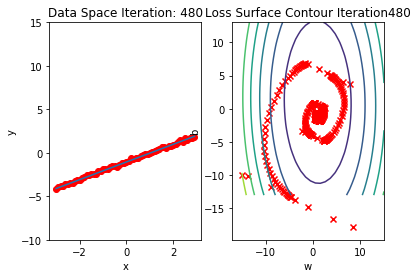

In [58]:
# Run 10 iterations

train_model_DataLoader(10)

Compare the loss of both batch gradient decent as SGD. Note that SGD converges to a minimum faster, that is, it decreases faster. 

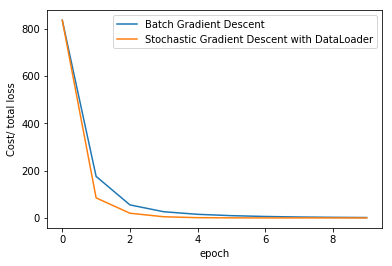

In [42]:
# Plot the LOSS_BGD and LOSS_Loader

plt.plot(LOSS_BGD,label="Batch Gradient Descent")
plt.plot(LOSS_Loader,label="Stochastic Gradient Descent with DataLoader")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

For practice, try to use SGD with DataLoader to train model with 10 iterations. Store the total loss in <code>LOSS</code>. We are going to use it in the next question.

In [60]:
# Practice: Use SGD with trainloader to train model and store the total loss in LOSS
LOSS = []
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

In [61]:
# Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

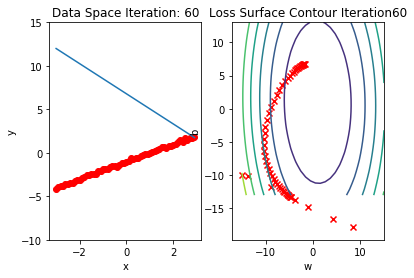

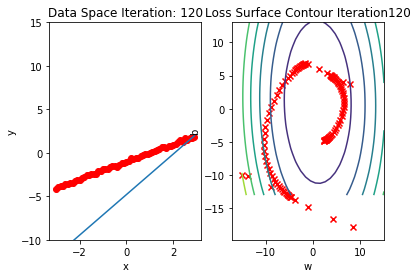

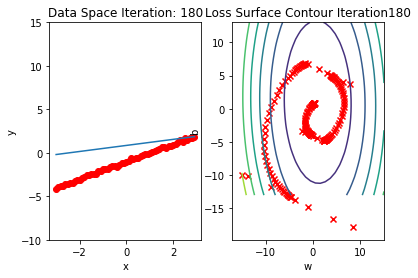

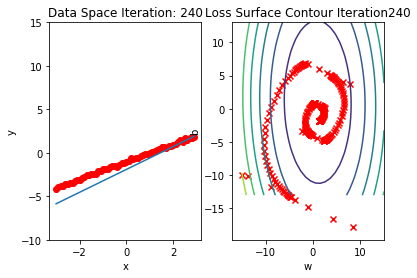

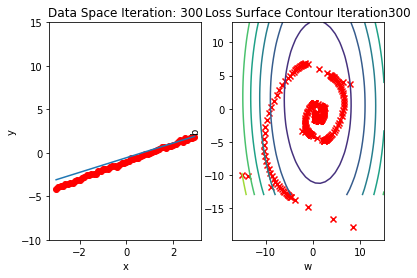

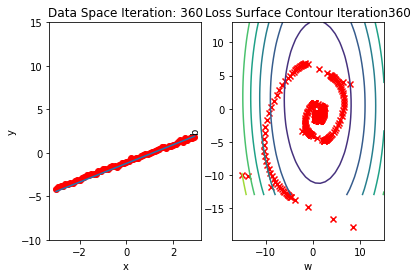

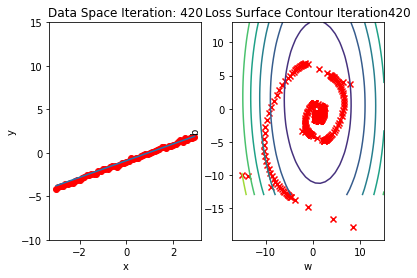

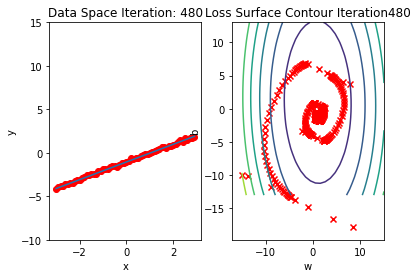

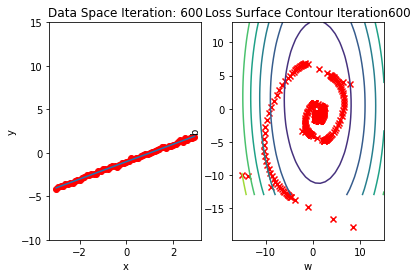

In [62]:
def my_train_model(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        LOSS.append(criterion(Yhat, X))
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()
        get_surface.plot_ps()
my_train_model(10)

<h2 id="Mini5">Mini Batch Gradient Descent: Batch Size Equals 5</h2> 

In [63]:
# Create DataLoader object and Data object
dataset = Data()
trainloader = DataLoader(dataset = dataset, batch_size = 5)

In [64]:
# Create a plot_error_surfaces object.
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

In [65]:
# Define train_model_Mini5 function

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
LOSS_MINI5 = []
lr = 0.1

def train_model_Mini5(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        LOSS_MINI5.append(criterion(forward(X), Y).tolist())
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()

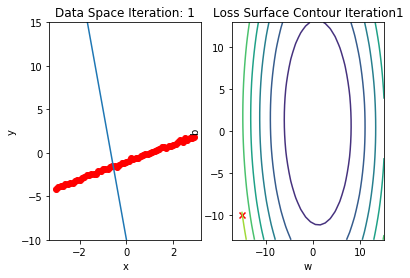

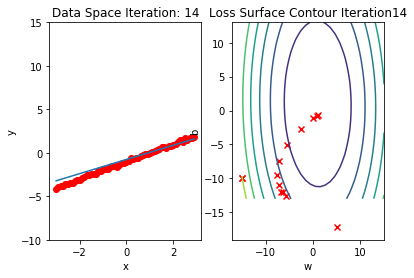

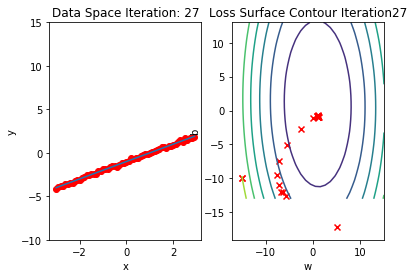

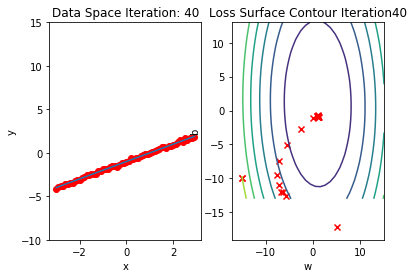

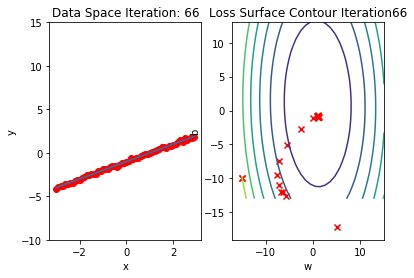

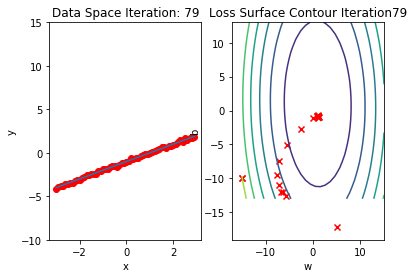

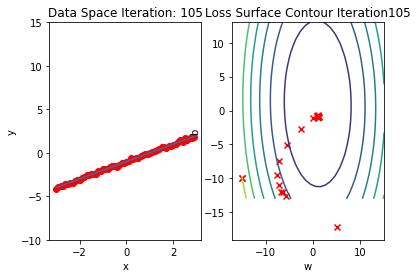

In [66]:
# Run train_model_Mini5 with 10 iterations.
train_model_Mini5(10)

<h2 id="Mini10">Mini Batch Gradient Descent: Batch Size Equals 10</h2> 

In [67]:
# Create a plot_error_surfaces object.
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

In [68]:
# Create DataLoader object
dataset = Data()
trainloader = DataLoader(dataset = dataset, batch_size = 10)

In [69]:
# Define train_model_Mini10 function
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
LOSS_MINI10 = []
lr = 0.1

def train_model_Mini10(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        LOSS_MINI10.append(criterion(forward(X),Y).tolist())
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()

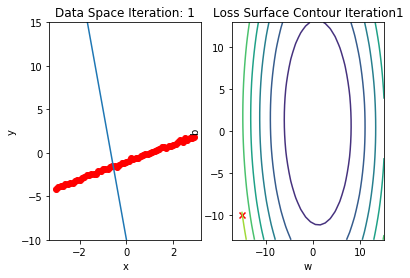

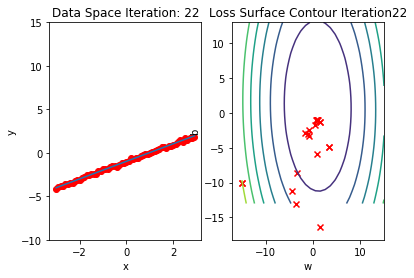

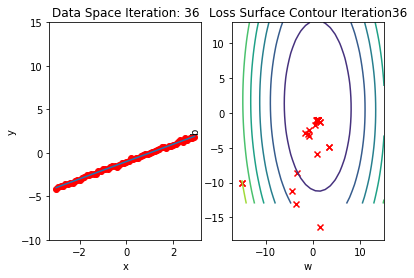

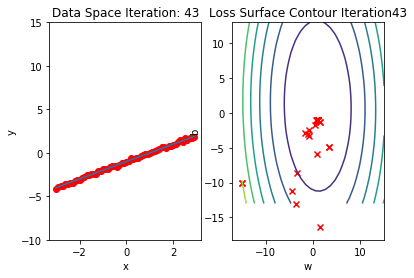

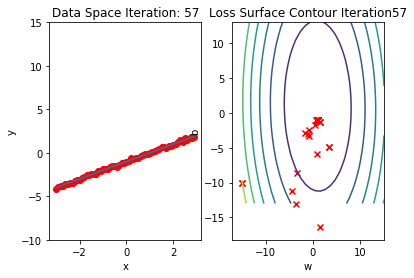

In [70]:
# Run train_model_Mini10 with 10 iterations.
train_model_Mini10(10)

In [71]:
# Plot out the LOSS for each method

plt.plot(LOSS_BGD,label = "Batch Gradient Descent")
plt.plot(LOSS_SGD,label = "Stochastic Gradient Descent")
plt.plot(LOSS_MINI5,label = "Mini-Batch Gradient Descent, Batch size: 5")
plt.plot(LOSS_MINI10,label = "Mini-Batch Gradient Descent, Batch size: 10")
plt.legend()